In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()

In [196]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from pattern import web
import brewer2mpl
import re
from lxml import etree
import urllib2
from BeautifulSoup import BeautifulSoup

In [8]:
#brewer2mpl makes it easier to use color tables from colorbrewer2.org in matplotlib
!pip install brewer2mpl

You are using pip version 7.0.1, however version 7.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [165]:
# Set up some better defaults for matplotlib
from matplotlib import rcParams

#colorbrewer2 Dark2 qualitative color table
dark2_colors = brewer2mpl.get_map('Dark2', 'Qualitative', 7).mpl_colors

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['patch.facecolor'] = dark2_colors[0]
rcParams['font.family'] = 'StixGeneral'


def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

simple analysis of polling data about the upcoming [Governer Races](https://en.wikipedia.org/wiki/Governor_(United_States))

#PART 1: Collect Data and Clean

Website: [Real Clear Politics](http://www.realclearpolitics.com/) <br/>
Data Links: Data used to generate plots are XML files like [this](http://charts.realclearpolitics.com/charts/1171.xml)

Problem 0: List the 5 tags from the XMl file

<ul style="list-style-type:square">
<li>chart
    <ul style="list-style-type:square">
        <li>series
            <ul style="list-style-type:circle">
            <li>value</li>
            </ul>
            </li>
        <li>graphs
            <ul style="list-style-type:circle">
                <li>graph
                <ul style="list-style-type:circle">
                    <li>value</li>
                    </ul>
                    </li>
                </ul>
                </li>
        </ul>
        </li>
</ul>

In [516]:
# Fill in the code for the get_poll_xml function, that finds and downloads an XML page discussed above
# requests.get("http://www.google.com").text downloads the text from Google's homepage
"""
Function
--------
get_poll_xml

Given a poll_id, return the XML data as a text string

Inputs
------
poll_id : int
    The ID of the poll to fetch

Returns
-------
xml : str
    The text of the XML page for that poll_id

Example
-------
>>> get_poll_xml(1044)
u'<?xml version="1.0" encoding="UTF-8"?><chart><series><value xid=\'0\'>1/27/2009</value>
...etc...
"""    

def get_poll_xml(poll_id):
    url = 'http://charts.realclearpolitics.com/charts/poll_id.xml'
    urlnew = re.sub(r'poll_id', str(poll_id), url)
    r = requests.get(urlnew)
#     print r.status_code
#     print r.headers['content-type']
#     print r.encoding
    #tree = ElementTree.fromstring(r.content)
    xmltree = etree.parse(urlnew)
    #root = xmltree.getroot()
    return etree.tostring(xmltree.getroot(), pretty_print=True), xmltree
#     print root.tag
#     print len(root)
#     for node in xmltree.iter():
#         print node.tag, node.attrib
#     for node in xmltree.findall('.//value'):
#         url = node.attrib.get('xid') 
#         print url

# XML file details:
# text/xml
# ISO-8859-1
#graph gid="2" color="#D30015" balloon_color="#D30015" title="Romney"

In [146]:
# "r"egular "e"xpressions is kind of a mini-language to
# do pattern matching on text
import re

def _strip(s):
    """This function removes non-letter characters from a word
    
    for example _strip('Hi there!') == 'Hi there'
    """
    return re.sub(r'[\W_]+', '', s)

def plot_colors(xml):
    """
    Given an XML document like the link above, returns a python dictionary
    that maps a graph title to a graph color.
    
    Both the title and color are parsed from attributes of the <graph> tag:
    <graph title="the title", color="#ff0000"> -> {'the title': '#ff0000'}
    
    These colors are in "hex string" format. This page explains them:
    http://coding.smashingmagazine.com/2012/10/04/the-code-side-of-color/
    
    Example
    -------
    >>> plot_colors(get_poll_xml(1044))
    {u'Approve': u'#000000', u'Disapprove': u'#FF0000'}
    """
    dom = web.Element(xml)
    result = {}
    for graph in dom.by_tag('graph'):
        title = _strip(graph.attributes['title'])
        result[title] = graph.attributes['color']
    return result

In [22]:
result = plot_colors(tree_str)

In [23]:
result

{u'Approve': u'#000000', u'Disapprove': u'#FF0000'}

In [445]:
tree_str, xmltree = get_poll_xml(1171)

In [88]:
date = [d.text for d in xmltree.xpath('/chart/series/value')]

In [89]:
len(date)

652

In [39]:
match=re.findall(r'<graph gid="(\d)" .* title="(\w*)">', tree_str)

In [81]:
column2 = [d.text for d in xmltree.xpath('./graphs/graph[@gid=1]/value')]

In [82]:
len(column2)

652

In [73]:
column3 = [d.text for d in xmltree.xpath('./graphs/graph[@gid=2]/value')]

In [80]:
len(column3)

652

In [23]:
print tree_str[:1000]

<chart>
  <series>
    <value xid="0">2/01/2011</value>
    <value xid="1">2/02/2011</value>
    <value xid="2">2/03/2011</value>
    <value xid="3">2/04/2011</value>
    <value xid="4">2/05/2011</value>
    <value xid="5">2/06/2011</value>
    <value xid="6">2/07/2011</value>
    <value xid="7">2/08/2011</value>
    <value xid="8">2/09/2011</value>
    <value xid="9">2/10/2011</value>
    <value xid="10">2/11/2011</value>
    <value xid="11">2/12/2011</value>
    <value xid="12">2/13/2011</value>
    <value xid="13">2/14/2011</value>
    <value xid="14">2/15/2011</value>
    <value xid="15">2/16/2011</value>
    <value xid="16">2/17/2011</value>
    <value xid="17">2/18/2011</value>
    <value xid="18">2/19/2011</value>
    <value xid="19">2/20/2011</value>
    <value xid="20">2/21/2011</value>
    <value xid="21">2/22/2011</value>
    <value xid="22">2/23/2011</value>
    <value xid="23">2/24/2011</value>
    <value xid="24">2/25/2011</value>
    <value xid="25">2/26/2011</value>
   

In [466]:
def rcp_poll_data(tree_str, xmltree):
    # For creating one column name as title_n where n=gid.
    match=re.findall(r'<graph gid="(\d)" .* title="(\S*)">', tree_str)
    for t in match:
        col2 = t[1]#+'_'+t[0]  

    for t in match:
        col1 = t[1] #+ '_' + t[0]
        break
    date = [d.text for d in xmltree.xpath('/chart/series/value')]
    column2 = [d.text if d.text else 0.0 for d in xmltree.xpath('./graphs/graph[@gid=1]/value')]
    column3 = [d.text if d.text else 0.0 for d in xmltree.xpath('./graphs/graph[@gid=2]/value')]
    
    frame = pd.DataFrame({'date' : pd.to_datetime(date,format='%m/%d/%Y'), col1 : column2, col2 : column3})
    return frame.sort(columns=['date'])

In [151]:
frame = rcp_poll_data(tree_str, xmltree)

In [467]:
def poll_plot(poll_id):
    """
    Make a plot of an RCP Poll over time.... 
    
    Parameters
    ----------
    poll_id : int
        An RCP poll identifier
    """

    # hey, you wrote two of these functions. Thanks for that!
    tree_str, xml = get_poll_xml(poll_id)
    data = rcp_poll_data(tree_str,xml)
    colors = plot_colors(tree_str)
    
    #remove characters like apostrophes
    data = data.rename(columns = {c: _strip(c) for c in data.columns})
    print colors
    #normalize poll numbers so they add to 100%    
    norm = data[colors.keys()].convert_objects(convert_numeric=True).sum(axis=1) / 100   
    for c in colors.keys():
        data[c] = data[c].astype(float)
        data[c] /= norm
    
    # plt.plot(x-axis, y-axis)
    
    for label, color in colors.items():
        plt.plot(data.date, data[label], color=color, label=label)        
    print colors.items()    
    plt.xticks(rotation=70)
    plt.legend(loc='best')
    plt.xlabel("Date")
    plt.ylabel("Normalized Poll Percentage")

{u'Romney': u'#D30015', u'Obama': u'#3B5998'}
[(u'Romney', u'#D30015'), (u'Obama', u'#3B5998')]


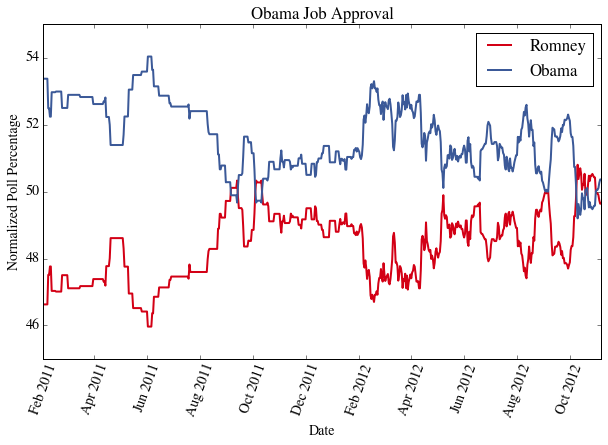

In [470]:
poll_plot(1171)
plt.title("Obama Job Approval")

{u'Ehrlich': u'#D30015', u'OMalley': u'#3B5998'}
[(u'Ehrlich', u'#D30015'), (u'OMalley', u'#3B5998')]


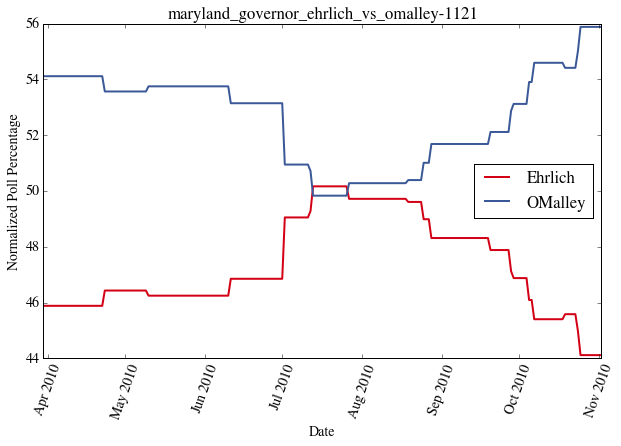

In [471]:
poll_plot(1121)
plt.title("maryland_governor_ehrlich_vs_omalley-1121")

#Part 2: Aggregate and Visualize
To get a sense of how accurate the RCP polls are, you will gather data from many previous Governor races, where the outcome is known.

In [212]:
def get_html_content(url):
    url = urllib2.urlopen(url).read()
    soup = BeautifulSoup(url)
    return soup

In [501]:
s = get_html_content('http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html')

In [505]:
# http://www.realclearpolitics.com/epolls/2010/governor/az/arizona_governor_brewer_vs_goddard-1409.html
def find_governor_races(htm):
    lst_gov_urls = []
    html_content = str(htm)
    for a in htm.findAll('a', href=True):
        link = str(a.get('href'))
        if link.startswith('/epolls'):
            complete_url = 'http://www.realclearpolitics.com'+link
            match_vs = re.findall(r'_vs_', complete_url)
            if len(match_vs) == 1:
                lst_gov_urls.append(complete_url)
    return lst_gov_urls

In [304]:
lst  = find_governor_races(s)

In [308]:
lst[0]

'http://www.realclearpolitics.com/epolls/2010/governor/ar/arkansas_governor_keet_vs_beebe-1568.html'

Problem 4:

At this point, you have functions to find a collection of governor races, download historical polling data from each one, parse them into a numerical DataFrame, and plot this data.

The main question we have about these data are how accurately they predict election outcomes. To answer this question, we need to grab the election outcome data.

In [425]:
def race_result(page):
    datasets = []
    result_dict={}
    page_content = get_html_content(page)
    #extract a table of a particular class
    table = page_content.find("table", attrs={"class":"data"})
    #The first tr contains the heading
    headings = [th.getText() for th in table.find("tr").findAll("th")]
    #extracting the tabl row that contains th result and then combining two lists using zip function
    for row in table.findAll("tr")[1:2]:
        dataset = zip(headings, (td.getText() for td in row.findAll("td")))
        datasets.append(dataset)

    for i in datasets[0][3:5]:
        result_dict[str(i[0]).split(" ")[0]]=float(i[1])
    return result_dict

In [552]:
def id_from_url(url):
    """Given a URL, look up the RCP identifier number"""
    return url.split('-')[-1].split('.html')[0]


def plot_race(url):
    """Make a plot summarizing a senate race
    
    Overplots the actual race results as dashed horizontal lines
    """
    #hey, thanks again for these functions!
    forbidden =['1235','1236','1627','1586','1429','1695','1310','1416','1454']
    id = id_from_url(url)
    if id not in forbidden: 
        str_tree, xml = get_poll_xml(id)    
        colors = plot_colors(str_tree)

        if len(colors) == 0:
            return

        #really, you shouldn't have
        result = race_result(url)

        poll_plot(id)
        plt.xlabel("Date")
        plt.ylabel("Polling Percentage")
        for r in result:
            plt.axhline(result[r], color=colors[_strip(r)], alpha=0.6, ls='--')

{u'Beebe': u'#3B5998', u'Keet': u'#D30015'}
[(u'Beebe', u'#3B5998'), (u'Keet', u'#D30015')]
Graph Number: 1


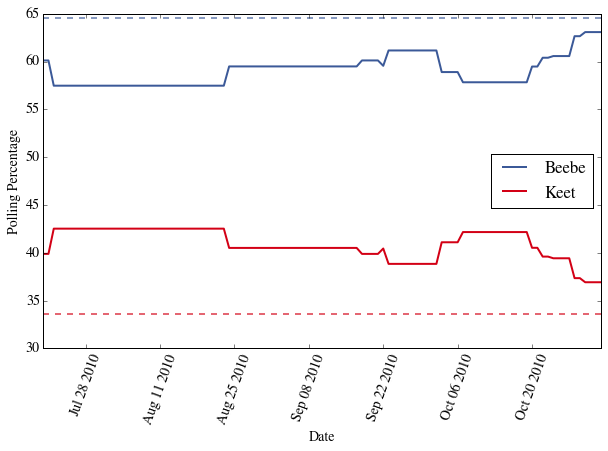

{u'Ehrlich': u'#D30015', u'OMalley': u'#3B5998'}
[(u'Ehrlich', u'#D30015'), (u'OMalley', u'#3B5998')]
Graph Number: 2


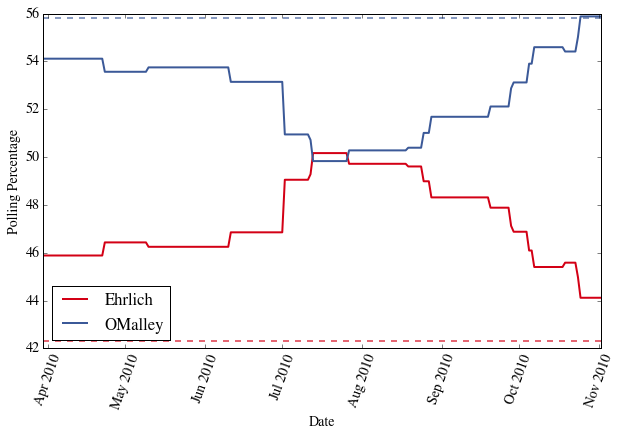

{u'Paladino': u'#D30015', u'Cuomo': u'#3B5998'}
[(u'Paladino', u'#D30015'), (u'Cuomo', u'#3B5998')]
Graph Number: 3


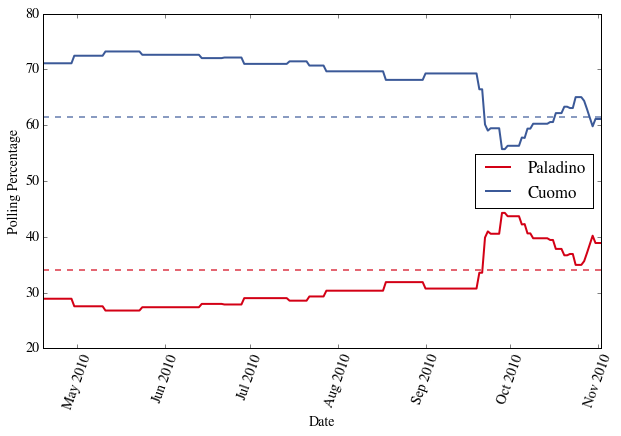

{u'Brown': u'#3B5998', u'Whitman': u'#D30015'}
[(u'Brown', u'#3B5998'), (u'Whitman', u'#D30015')]
Graph Number: 4


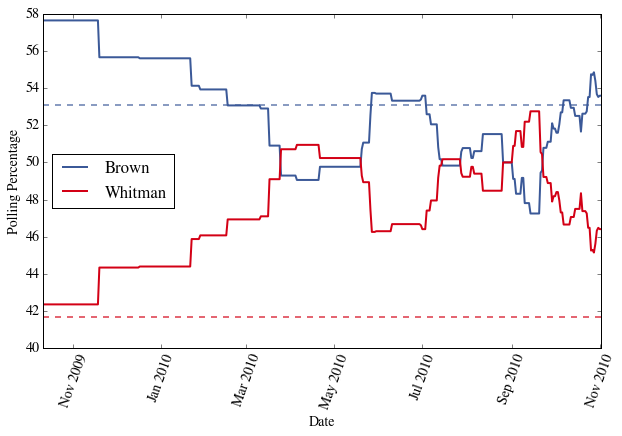

{u'Stephen': u'#D30015', u'Lynch': u'#3B5998'}
[(u'Stephen', u'#D30015'), (u'Lynch', u'#3B5998')]
Graph Number: 5


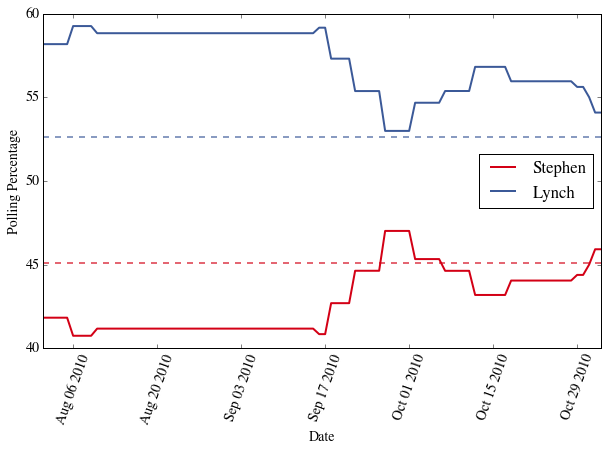

{u'Foley': u'#D30015', u'Malloy': u'#3B5998'}
[(u'Foley', u'#D30015'), (u'Malloy', u'#3B5998')]
Graph Number: 6


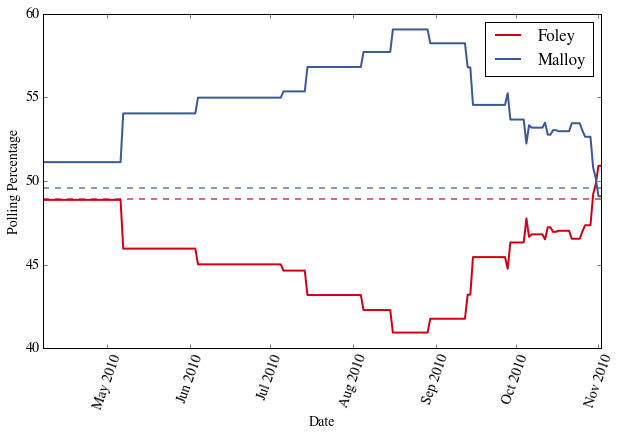

Graph Number: 7
{u'Brady': u'#D30015', u'Quinn': u'#3B5998'}
[(u'Brady', u'#D30015'), (u'Quinn', u'#3B5998')]
Graph Number: 8


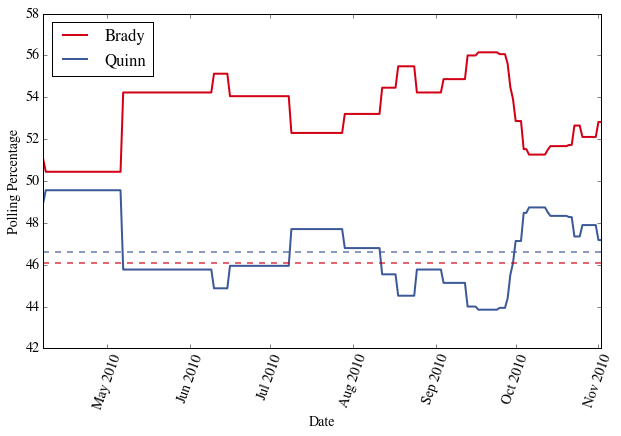

{u'Strickland': u'#3B5998', u'Kasich': u'#D30015'}
[(u'Strickland', u'#3B5998'), (u'Kasich', u'#D30015')]
Graph Number: 9


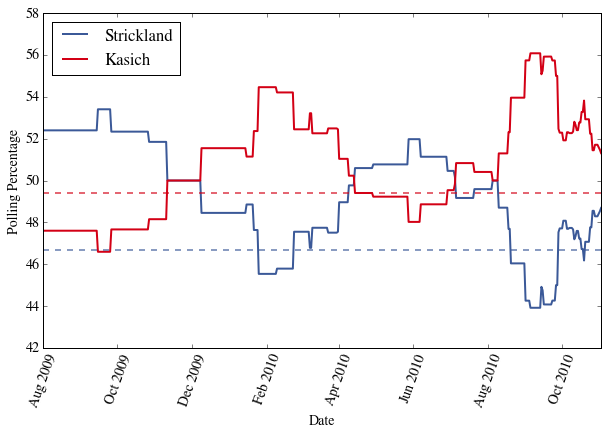

{u'Kitzhaber': u'#3B5998', u'Dudley': u'#D30015'}
[(u'Kitzhaber', u'#3B5998'), (u'Dudley', u'#D30015')]
Graph Number: 10


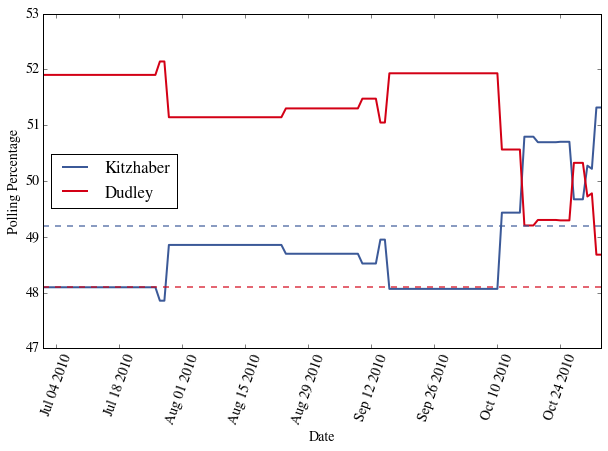

Graph Number: 11
{u'Goddard': u'#3B5998', u'Brewer': u'#D30015'}
[(u'Goddard', u'#3B5998'), (u'Brewer', u'#D30015')]
Graph Number: 12


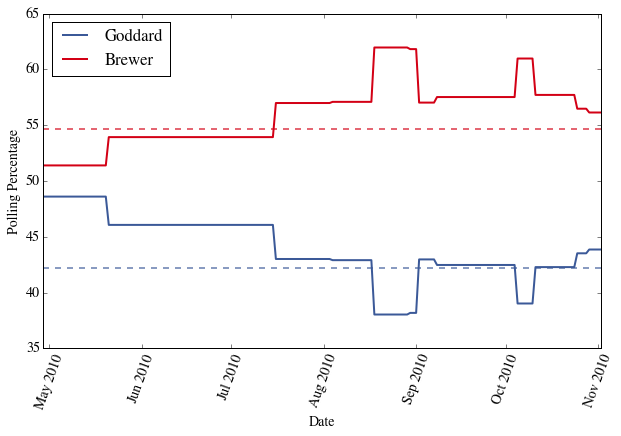

{u'Barnes': u'#3B5998', u'Deal': u'#D30015'}
[(u'Barnes', u'#3B5998'), (u'Deal', u'#D30015')]
Graph Number: 13


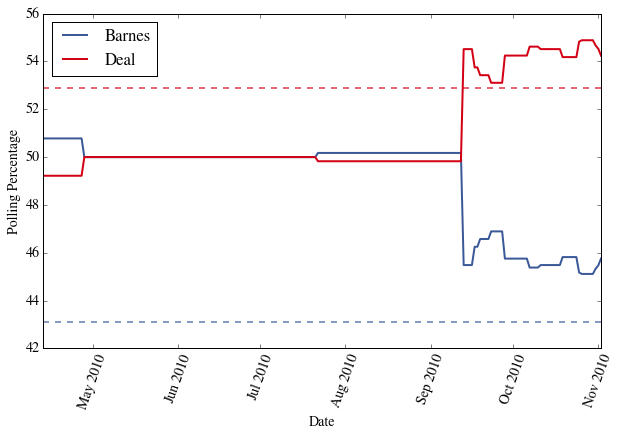

{u'Martinez': u'#D30015', u'Denish': u'#3B5998'}
[(u'Martinez', u'#D30015'), (u'Denish', u'#3B5998')]
Graph Number: 14


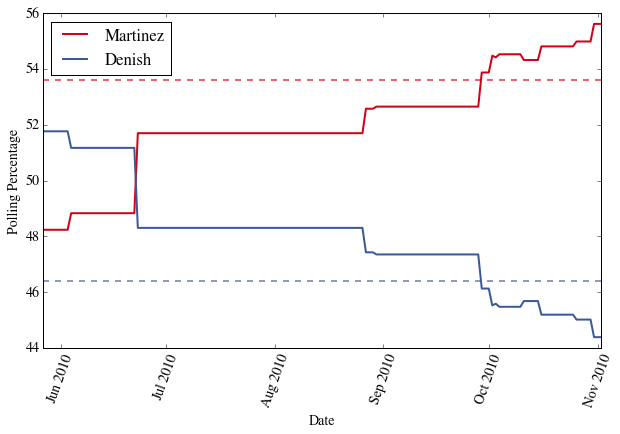

{u'Corbett': u'#D30015', u'Onorato': u'#3B5998'}
[(u'Corbett', u'#D30015'), (u'Onorato', u'#3B5998')]
Graph Number: 15


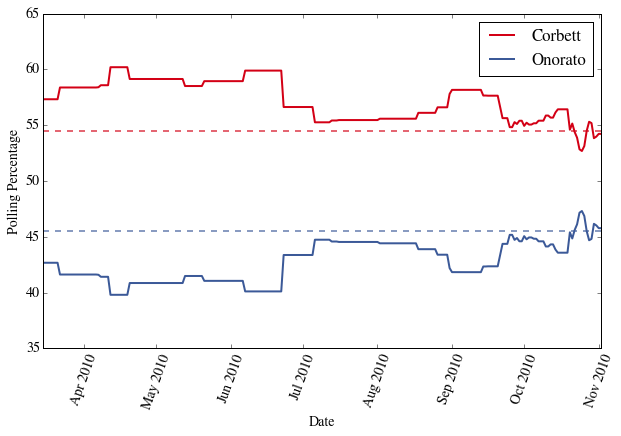

{u'Haley': u'#D30015', u'Sheheen': u'#3B5998'}
[(u'Haley', u'#D30015'), (u'Sheheen', u'#3B5998')]
Graph Number: 16


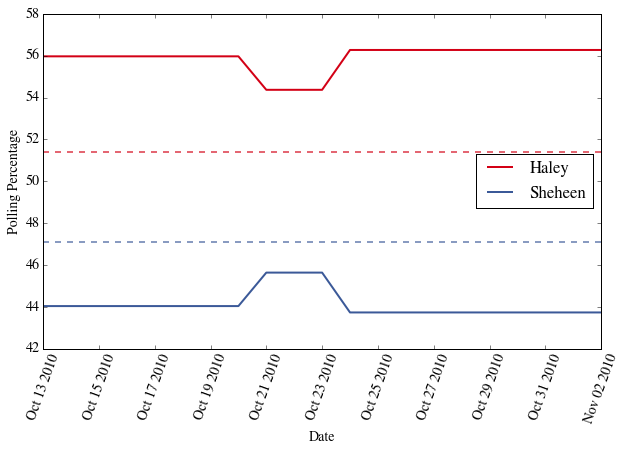

{u'White': u'#3B5998', u'Perry': u'#D30015'}
[(u'White', u'#3B5998'), (u'Perry', u'#D30015')]
Graph Number: 17


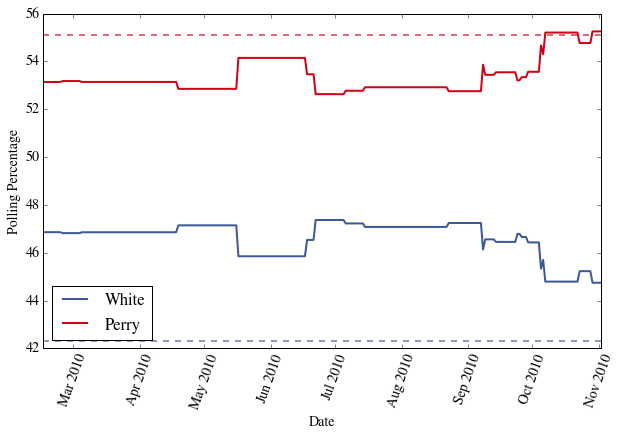

{u'Walker': u'#D30015', u'Barrett': u'#3B5998'}
[(u'Walker', u'#D30015'), (u'Barrett', u'#3B5998')]
Graph Number: 18


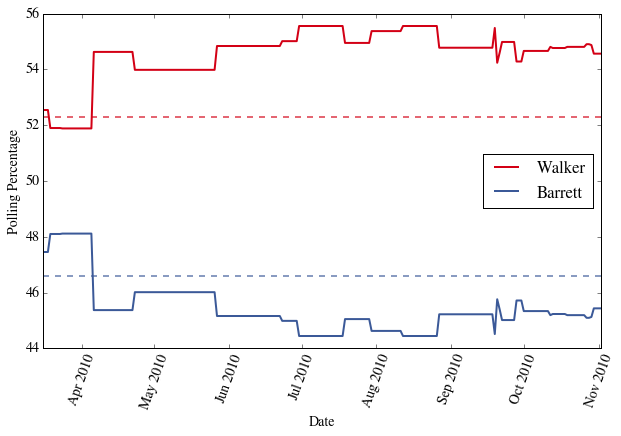

{u'Berkowitz': u'#3B5998', u'Parnell': u'#D30015'}
[(u'Berkowitz', u'#3B5998'), (u'Parnell', u'#D30015')]
Graph Number: 19


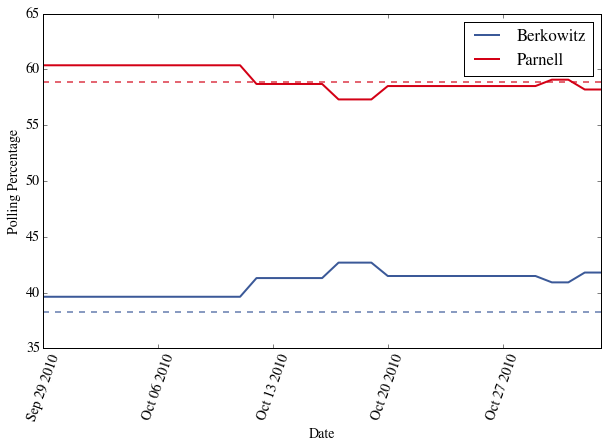

{u'Culver': u'#3B5998', u'Branstad': u'#D30015'}
[(u'Culver', u'#3B5998'), (u'Branstad', u'#D30015')]
Graph Number: 20


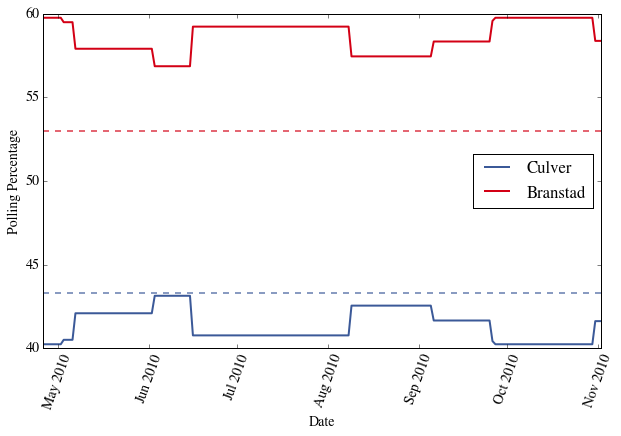

{u'Snyder': u'#D30015', u'Bernero': u'#3B5998'}
[(u'Snyder', u'#D30015'), (u'Bernero', u'#3B5998')]
Graph Number: 21


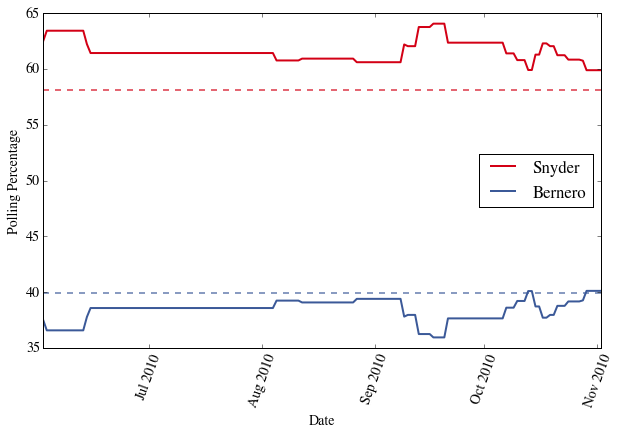

{u'Reid': u'#3B5998', u'Sandoval': u'#D30015'}
[(u'Reid', u'#3B5998'), (u'Sandoval', u'#D30015')]
Graph Number: 22


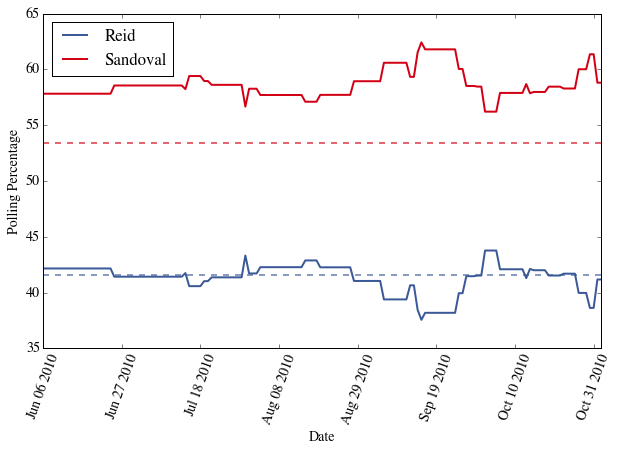

{u'Brown': u'#3B5998', u'Whitman': u'#D30015'}
[(u'Brown', u'#3B5998'), (u'Whitman', u'#D30015')]
Graph Number: 23


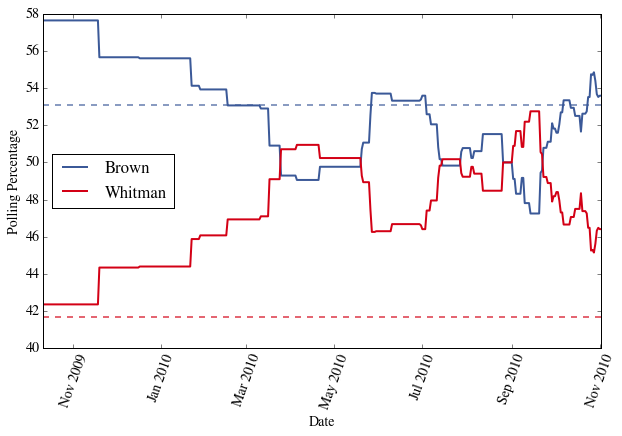

{u'Martinez': u'#D30015', u'Denish': u'#3B5998'}
[(u'Martinez', u'#D30015'), (u'Denish', u'#3B5998')]
Graph Number: 24


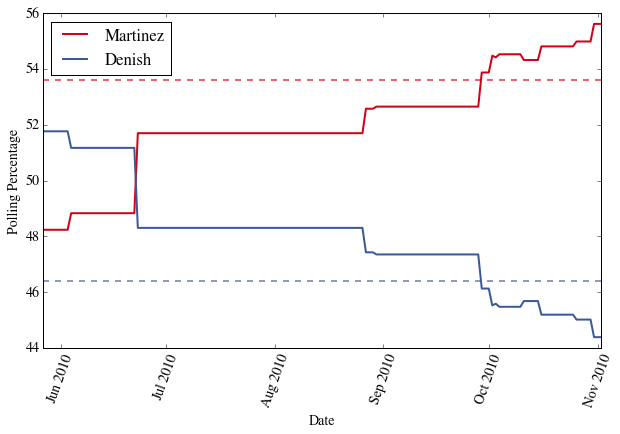

{u'Corbett': u'#D30015', u'Onorato': u'#3B5998'}
[(u'Corbett', u'#D30015'), (u'Onorato', u'#3B5998')]
Graph Number: 25


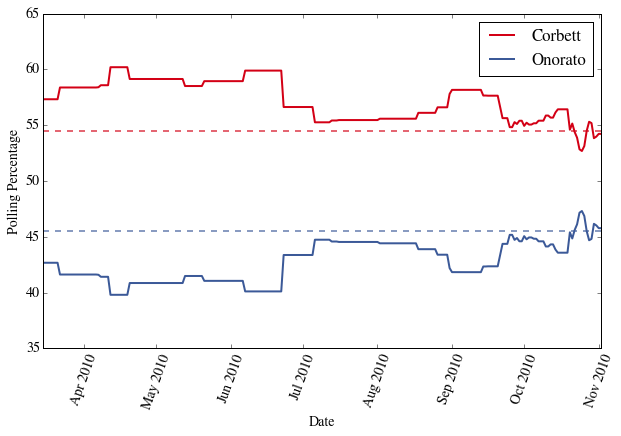

{u'Walker': u'#D30015', u'Barrett': u'#3B5998'}
[(u'Walker', u'#D30015'), (u'Barrett', u'#3B5998')]
Graph Number: 26


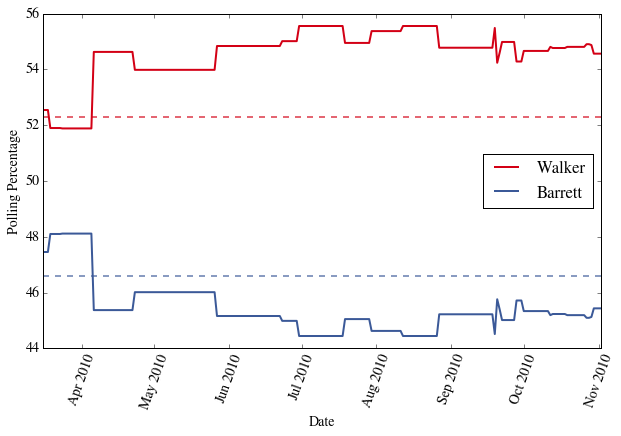

{u'Culver': u'#3B5998', u'Branstad': u'#D30015'}
[(u'Culver', u'#3B5998'), (u'Branstad', u'#D30015')]
Graph Number: 27


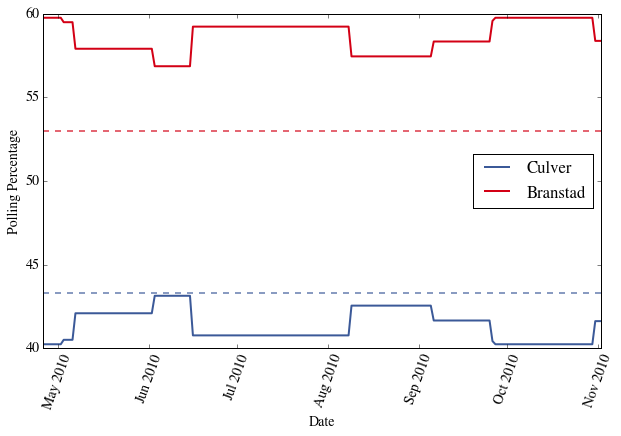

{u'Snyder': u'#D30015', u'Bernero': u'#3B5998'}
[(u'Snyder', u'#D30015'), (u'Bernero', u'#3B5998')]
Graph Number: 28


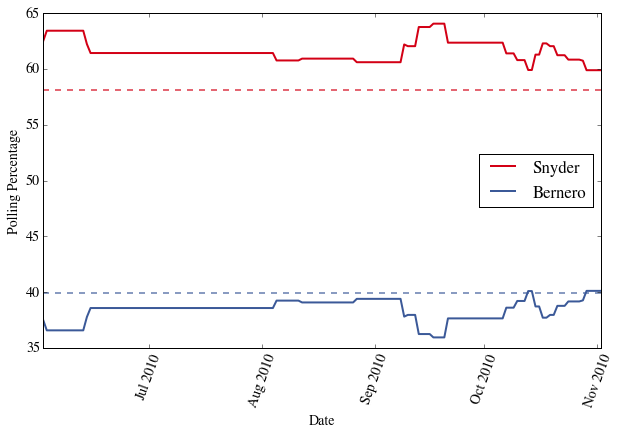

Graph Number: 29
Graph Number: 30
Graph Number: 31
Graph Number: 32
{u'Goddard': u'#3B5998', u'Brewer': u'#D30015'}
[(u'Goddard', u'#3B5998'), (u'Brewer', u'#D30015')]
Graph Number: 33


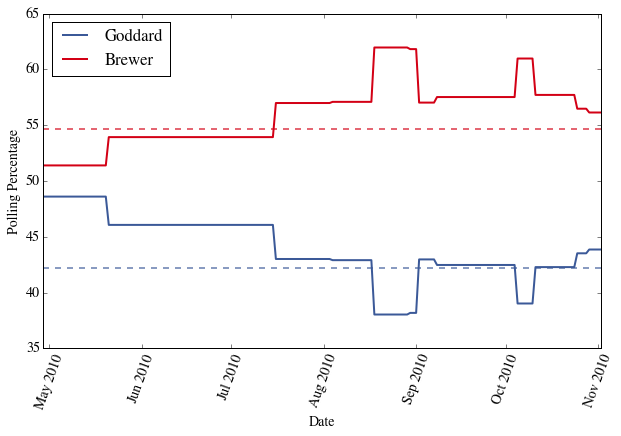

{u'Stephen': u'#D30015', u'Lynch': u'#3B5998'}
[(u'Stephen', u'#D30015'), (u'Lynch', u'#3B5998')]
Graph Number: 34


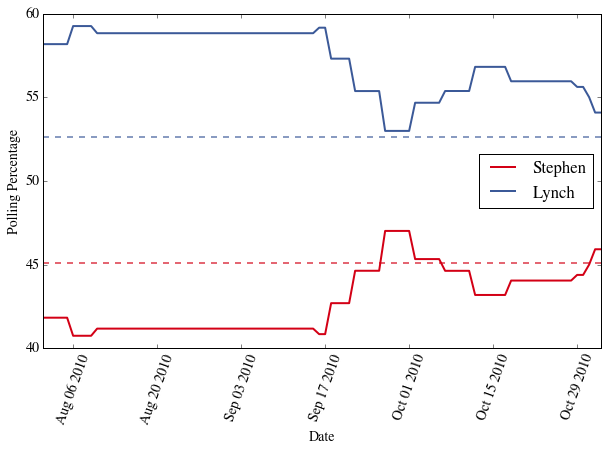

{u'Foley': u'#D30015', u'Malloy': u'#3B5998'}
[(u'Foley', u'#D30015'), (u'Malloy', u'#3B5998')]
Graph Number: 35


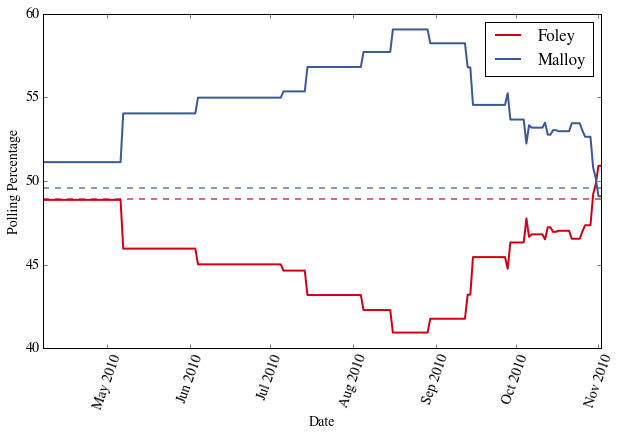

{u'Ehrlich': u'#D30015', u'OMalley': u'#3B5998'}
[(u'Ehrlich', u'#D30015'), (u'OMalley', u'#3B5998')]
Graph Number: 36


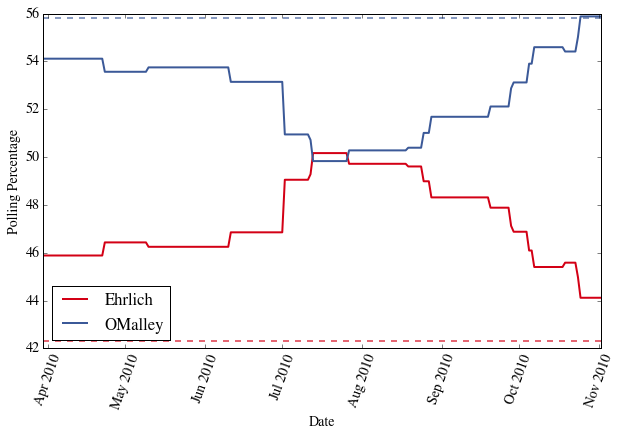

{u'Brown': u'#3B5998', u'Whitman': u'#D30015'}
[(u'Brown', u'#3B5998'), (u'Whitman', u'#D30015')]
Graph Number: 37


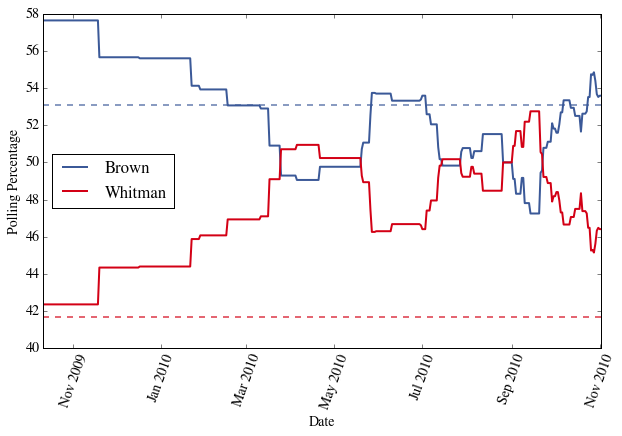

Graph Number: 38
Graph Number: 39
Graph Number: 40
Graph Number: 41
Graph Number: 42
Graph Number: 43
Graph Number: 44
Graph Number: 45
Graph Number: 46


In [553]:
#page = requests.get('http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html').text.encode('ascii', 'ignore')
page=get_html_content('http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html')
c=1
for race in find_governor_races(page):
    plot_race(race)
    print "Graph Number:",c
    c += 1
    plt.show()

In [554]:
page=get_html_content('http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html')
for race in find_governor_races(page):
    print race
    

http://www.realclearpolitics.com/epolls/2010/governor/ar/arkansas_governor_keet_vs_beebe-1568.html
http://www.realclearpolitics.com/epolls/2010/governor/md/maryland_governor_ehrlich_vs_omalley-1121.html
http://www.realclearpolitics.com/epolls/2010/governor/ny/new_york_governor_paladino_vs_cuomo-1423.html
http://www.realclearpolitics.com/epolls/2010/governor/ca/california_governor_whitman_vs_brown-1113.html
http://www.realclearpolitics.com/epolls/2010/governor/nh/new_hampshire_governor_stephen_vs_lynch-1446.html
http://www.realclearpolitics.com/epolls/2010/governor/ct/connecticut_governor_foley_vs_malloy-1357.html
http://www.realclearpolitics.com/epolls/2010/governor/hi/hawaii_governor_aiona_vs_abercrombie-1163.html
http://www.realclearpolitics.com/epolls/2010/governor/il/illinois_governor_brady_vs_quinn-1361.html
http://www.realclearpolitics.com/epolls/2010/governor/oh/ohio_governor_kasich_vs_strickland-1078.html
http://www.realclearpolitics.com/epolls/2010/governor/or/oregon_governor_

#Part 3: Analysis

In [559]:
def party_from_color(color):
    if color in ['#0000CC', '#3B5998']:
        return 'democrat'
    if color in ['#FF0000', '#D30015']:
        return 'republican'
    return 'other'


def error_data(url):
    """
    Given a Governor race URL, download the poll data and race result,
    and construct a DataFrame with the following columns:
    
    candidate: Name of the candidate
    forecast_length: Number of days before the election
    percentage: The percent of poll votes a candidate has.
                Normalized to that the canddidate percentages add to 100%
    error: Difference between percentage and actual race reulst
    party: Political party of the candidate
    
    The data are resampled as necessary, to provide one data point per day
    """
    forbidden =['1235','1236','1627','1586','1429','1695','1310','1416','1454']
    id = id_from_url(url)
    if id not in forbidden:
        str_tree, xml = get_poll_xml(id)

        colors = plot_colors(str_tree)
        if len(colors) == 0:
            return pd.DataFrame()

        df = rcp_poll_data(str_tree,xml)
        result = race_result(url)

        #remove non-letter characters from columns
        df = df.rename(columns={c: _strip(c) for c in df.columns})
        for k, v in result.items():
            result[_strip(k)] = v 

        candidates = [c for c in df.columns if c is not 'date']

        #turn into a timeseries...
        df.index = df.date

        #...so that we can resample at regular, daily intervals
        df = df.resample('D')
        df = df.dropna()

        #compute forecast length in days
        #(assuming that last forecast happens on the day of the election, for simplicity)
        forecast_length = (df.date.max() - df.date).values
        forecast_length = forecast_length / np.timedelta64(1, 'D')  # convert to number of days

        #compute forecast error
        errors = {}
        normalized = {}
        poll_lead = {}

        for c in candidates:
            #turn raw percentage into percentage of poll votes
            corr = df[c].convert_objects(convert_numeric=True).values / df[candidates].convert_objects(convert_numeric=True).sum(axis=1).values * 100.
            err = corr - result[_strip(c)]

            normalized[c] = corr
            errors[c] = err

        n = forecast_length.size

        result = {}
        result['percentage'] = np.hstack(normalized[c] for c in candidates)
        result['error'] = np.hstack(errors[c] for c in candidates)
        result['candidate'] = np.hstack(np.repeat(c, n) for c in candidates)
        result['party'] = np.hstack(np.repeat(party_from_color(colors[_strip(c)]), n) for c in candidates)
        result['forecast_length'] = np.hstack(forecast_length for _ in candidates)

        result = pd.DataFrame(result)
        return result

In [565]:
"""
function
---------
all_error_data

Calls error_data on all races from find_governer_races(page),
and concatenates into a single DataFrame

Parameters
-----------
None

Examples
--------
df = all_error_data()
"""

def all_error_data():
    lst_df = []
    page=get_html_content('http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html')
    for race in find_governor_races(page):
        df=error_data(race)
        lst_df.append(df)
    concat_df = pd.concat(lst_df, ignore_index=True)
    return concat_df

In [568]:
page=get_html_content('http://www.realclearpolitics.com/epolls/2010/governor/2010_elections_governor_map.html')
for race in find_governor_races(page):
    df=error_data(race)
    print df
    break

    candidate     error  forecast_length       party  percentage
0       Beebe -4.390110              112    democrat   60.109890
1       Beebe -4.390110              111    democrat   60.109890
2       Beebe -7.027473              110    democrat   57.472527
3       Beebe -7.027473              109    democrat   57.472527
4       Beebe -7.027473              108    democrat   57.472527
5       Beebe -7.027473              107    democrat   57.472527
6       Beebe -7.027473              106    democrat   57.472527
7       Beebe -7.027473              105    democrat   57.472527
8       Beebe -7.027473              104    democrat   57.472527
9       Beebe -7.027473              103    democrat   57.472527
10      Beebe -7.027473              102    democrat   57.472527
11      Beebe -7.027473              101    democrat   57.472527
12      Beebe -7.027473              100    democrat   57.472527
13      Beebe -7.027473               99    democrat   57.472527
14      Beebe -7.027473  

In [569]:
final_df

,candidate,error,forecast_length,party,percentage
0,Beebe,-4.390110,112,democrat,60.109890
1,Beebe,-4.390110,111,democrat,60.109890
2,Beebe,-7.027473,110,democrat,57.472527
3,Beebe,-7.027473,109,democrat,57.472527
4,Beebe,-7.027473,108,democrat,57.472527
5,Beebe,-7.027473,107,democrat,57.472527
6,Beebe,-7.027473,106,democrat,57.472527
7,Beebe,-7.027473,105,democrat,57.472527
8,Beebe,-7.027473,104,democrat,57.472527
9,Beebe,-7.027473,103,democrat,57.472527


In [566]:
final_df = all_error_data()

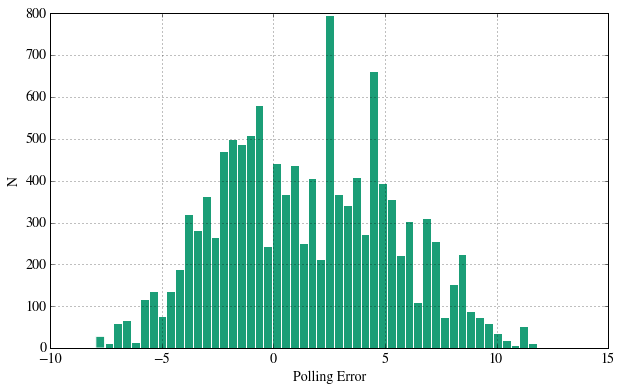

In [571]:
#Here's a histogram of the error of every polling measurement in the data
final_df.error.hist(bins=50)
plt.xlabel("Polling Error")
plt.ylabel('N')

In [572]:
#Compute the standard deviation of the polling errors. How much uncertainty is there in the typical RCP poll?
final_df.error.std()

3.8819265898911537

Some general Data Analysis on final_df Dataframe.

In [575]:
final_df[['candidate', 'error','forecast_length','party','percentage']].describe()

,error,forecast_length,percentage
count,12586.000000,13020.000000,12586.000000
mean,1.491824,126.645161,50.000000
std,3.881927,94.337235,6.647874
min,-7.954054,0.000000,26.785714
25%,-1.549239,53.000000,45.504386
50%,1.515578,110.000000,50.000000
75%,4.447368,177.000000,54.495614
max,11.814286,465.000000,73.214286


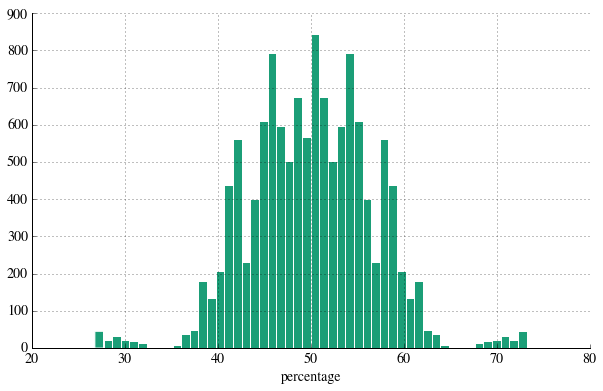

In [578]:
final_df.percentage.hist(bins=50)
plt.xlabel('percentage')
remove_border()

In [582]:
#Repeat this calculation for the data where errors.forecast_length < 7 (i.e. the polls within a week of an election). 
#How much more/less accurate are they? How about the data where errors.forecast_length > 30?

print "Standard Deviation when forecast length < 7 is:", final_df[final_df.forecast_length < 14].error.std()
print "Standard Deviation when forecast length > 30 is:", final_df[final_df.forecast_length > 30].error.std()

Standard Deviation when forecast length < 7 is: 2.28250493985
Standard Deviation when forecast length > 30 is: 4.01646199915


We can expect this result in error standard deviation, the accuracy of polls shortly before the election is only 2.28 and more accurate than polls more than a month before the election, where standard deviation is 4.01